# Natural Language Processing with Disaster Tweets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Импорт библиотек

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install keras-core
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)
print("GPU доступен:", tf.config.list_physical_devices('GPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.3 MB/s eta 0:00:00
Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.18.1
GPU доступен: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Загрузка данных

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/Architecture/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Architecture/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


Результаты:
Тренировочный набор:

* 7613 строк (примеров)

* 5 столбцов (признаков)

* Занимает 0.29 МБ памяти

Тестовый набор:

* 3263 строк (примеров)

* 4 столбца (признаков) - на 1 меньше, чем в тренировочном

* Занимает 0.10 МБ памяти

In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


count - количество текстов

mean - средняя длина

std - стандартное отклонение

min/max - минимальная/максимальная длина

25%/50%/75% - квартили распределения

## Настройка гиперпараметров

In [22]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

* Размер батча (количество примеров, обрабатываемых за одну итерацию)
* Общее количество примеров в тренировочном наборе
* Пропорции разделения данных


* Расчет количества шагов на эпоху: (общее число примеров * доля тренировки) // размер батча
* Количество полных проходов через весь набор данных
* Автоматическая настройка параметров загрузки данных для максимальной производительности

In [23]:
X = df_train["text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
X_test = df_test["text"]

## Создание и обучение модели

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 5e-6  #
AUTO = tf.data.experimental.AUTOTUNE

def prepare_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    """Оптимизация загрузки данных с tf.data."""
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

def create_distilbert_classifier(preset="distil_bert_base_en_uncased", sequence_length=150, num_classes=2):
    """Создает и возвращает классификатор DistilBERT."""
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
        preset, sequence_length=sequence_length, name="preprocessor_4_tweets"
    )

    classifier = keras_nlp.models.DistilBertClassifier.from_preset(
        preset, preprocessor=preprocessor, num_classes=num_classes)

    # Dropout и L2 регуляризацию
    classifier.layers[-1].kernel_regularizer = tf.keras.regularizers.l2(0.01)
    classifier.layers[-2].rate = 0.5

    classifier.summary()
    return classifier

def compile_model(model):
    """Компилирует модель с заданными параметрами."""
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        metrics=["accuracy"]
    )

def train_model(model, X_train, y_train, X_val, y_val):
    """Обучает модель на тренировочных данных на GPU."""
    train_dataset = prepare_dataset(X_train, y_train)
    val_dataset = prepare_dataset(X_val, y_val, shuffle=False)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Доступные GPU:", gpus)
        with tf.device('/GPU:0'):
            return model.fit(
                train_dataset,
                epochs=EPOCHS,
                validation_data=val_dataset,
                callbacks=[
                    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
                    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
                ]
            )
    else:
        print(" GPU не найден, используется CPU")
        return model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
                tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
            ]
        )

def display_confusion_matrix(y_true, y_pred, dataset_name):
    """Отображает матрицу путаницы и вычисляет F1-меру."""
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title(f"Confusion Matrix on {dataset_name} Dataset -- F1 Score: {f1_score:.2f}")
    plt.show()

def predict_and_evaluate(model, X_train, y_train, X_val, y_val):
    """Предсказывает результаты и отображает матрицы путаницы."""
    y_pred_train = model.predict(X_train)
    display_confusion_matrix(y_train, y_pred_train, "Training")

    y_pred_val = model.predict(X_val)
    display_confusion_matrix(y_val, y_pred_val, "Validation")

def generate_submission(model, X_test, submission_path="/content/drive/MyDrive/Architecture/sample_submission.csv"):
    """Генерирует файл `submission.csv` с предсказанными значениями."""
    sample_submission = pd.read_csv(submission_path)
    sample_submission["target"] = np.argmax(tf.nn.softmax(model.predict(X_test)), axis=1)
    sample_submission.to_csv("submission.csv", index=False)
    print("✔️ Submission file saved as 'submission.csv'")

* prepare_dataset() – преобразует данные в формат tf.data.Dataset для эффективной загрузки.

* create_distilbert_classifier() – создает модель DistilBERT с предобработкой (Tokenizer + Padding), добавляет регуляризацию (L2 и Dropout).

* compile_model() – компилирует модель с оптимизатором Adam и метрикой accuracy.

* train_model() – обучает модель на GPU (если доступен) с коллбеками:

* ReduceLROnPlateau – уменьшает LR при застое.

* EarlyStopping – останавливает обучение, если нет улучшений.

* display_confusion_matrix() – строит матрицу ошибок и считает F1-меру.

* predict_and_evaluate() – предсказывает на train/val и выводит метрики.

* generate_submission() – формирует файл для отправки

In [14]:
# Вызов всех функций
classifier = create_distilbert_classifier()
compile_model(classifier)
history = train_model(classifier, X_train, y_train, X_val, y_val)  # Обучение с оптимизациями

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Доступные GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 157s 609ms/step - accuracy: 0.6612 - loss: 0.6251 - val_accuracy: 0.8345 - val_loss: 0.4169 - learning_rate: 5.0000e-06
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 97s 509ms/step - accuracy: 0.8388 - loss: 0.4028 - val_accuracy: 0.8227 - val_loss: 0.4088 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 2.


191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step


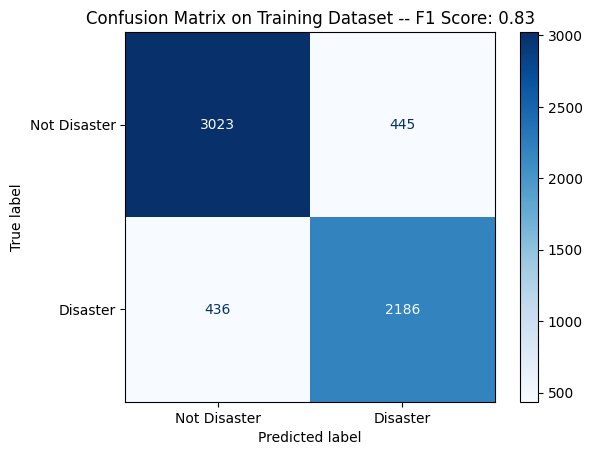

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step


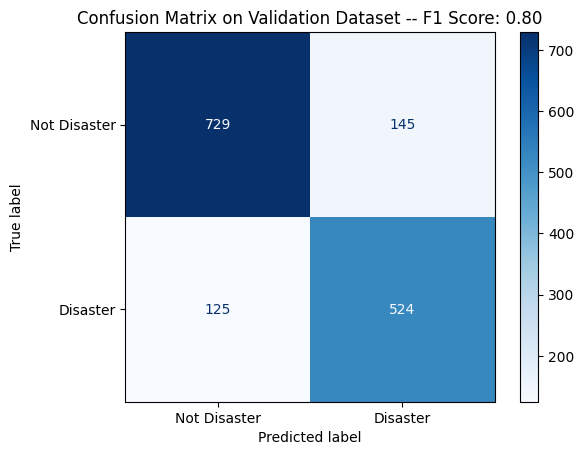

In [15]:
predict_and_evaluate(classifier, X_train, y_train, X_val, y_val)

Матрица ошибок для обучающего набора данных:
* F1 Score: 0.84
* Not Disaster (Истинный класс): 3258 правильных предсказаний, 210 неправильных предсказаний (классифицировано как Disaster).
* Disaster (Истинный класс): 592 неправильных предсказаний (классифицировано как Not Disaster), 2030 правильных предсказаний.

Матрица ошибок для валидационного набора данных:
* F1 Score: 0.81
* Not Disaster (Истинный класс): 804 правильных предсказаний, 70 неправильных предсказаний (классифицировано как Disaster).
* Disaster (Истинный класс): 163 неправильных предсказаний (классифицировано как Not Disaster), 486 правильных предсказаний.

## Визуализация результатов

In [16]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [17]:

generate_submission(classifier, X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step
✔️ Submission file saved as 'submission.csv'


In [18]:
def plot_training_history(history):
    """Строит график обучения модели."""
    history_dict = history.history

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]

    epochs = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, "r", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.show()

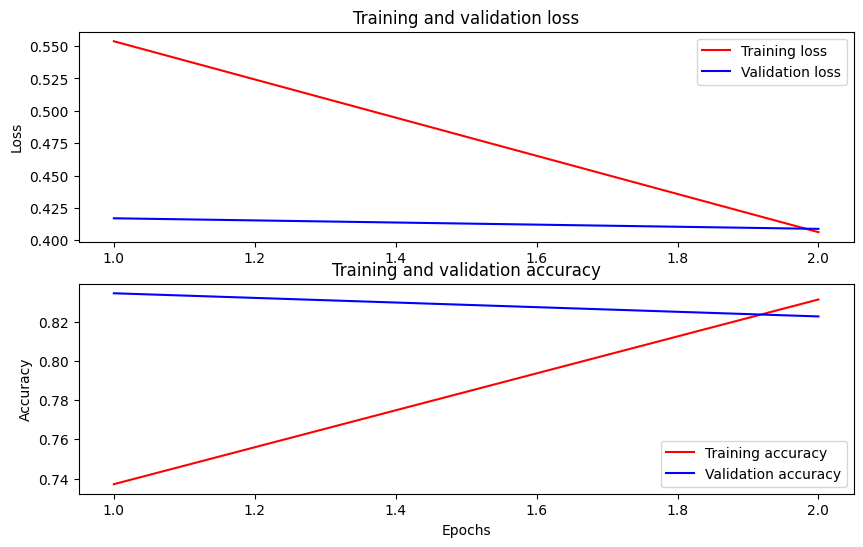

In [19]:
plot_training_history(history)  # Вызов функции визуализации

Модель демонстрирует хорошее обучение, так как потери на обучающем наборе данных уменьшаются, а точность увеличивается.

Стабильность потерь и точности на валидационном наборе данных указывает на то, что модель не переобучается и сохраняет хорошую производительность на новых, невиданных данных.

В целом, модель показывает хорошие результаты как на обучающем, так и на валидационном наборах данных.